Juypter notebook focusing on the investigation and use of the MS COCO dataset. This was created for CSU's CS445

The goal of this model is to recognize and select cats, dogs, cows, horses, and birds out of a photo

Contributers: Tucker Laurence, Yasas Wijesekara

In [107]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
import urllib.request

Global variables used to select conditions about the dataset


In [108]:
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']

This section focuses on the importing and loading of the dataset VIA pycotools.coco, which is the official access tools for MS COCO

In [109]:
def create_coco(annotation_directory, data_name, categories):
    annFile='{}/instances_{}.json'.format(annotation_directory,data_name)
    coco=COCO(annFile)
    image_ids = []
    
    category_ids = coco.getCatIds(catNms=categories)
    for category in category_ids:
        temp_img_ids = imgIds = coco.getImgIds(catIds=category)
        image_ids += temp_img_ids
    
    print(f"Found {len(image_ids)} images for {categories}")
    
    return category_ids, image_ids, coco
        

In [110]:
def download_coco_images(coco, imgIds, save_dir, verbose=False):
    current_image_count = 1
    total_image_count = len(imgIds)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for img_id in imgIds:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        url = img_info.get('coco_url')
        
        img_count_string = f'{current_image_count}/{total_image_count}'

        if url is None:
            print(f"No URL found for image {file_name}, skipping.")
            continue

        save_path = os.path.join(save_dir, file_name)
        if not os.path.exists(save_path):
            try:
                urllib.request.urlretrieve(url, save_path)
                if verbose: print(f"{img_count_string} Downloaded {file_name}")
            except Exception as e:
                if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
        else:
            if verbose: print(f"{img_count_string} Image already exists: {file_name}")
        
        current_image_count += 1
    
    print(f'Interfaced with {current_image_count-1} images')

In [111]:
def display_image(img):
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()

def display_bounded_image(coco, img, category_ids):
    I = io.imread(img['coco_url'])
    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=category_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)

In [112]:
val_category_ids, val_image_ids, val_coco = create_coco(annotation_dir, val_data_name, relevant_categories)

loading annotations into memory...
Done (t=2.29s)
creating index...
index created!
Found 701 images for ['cat', 'dog', 'cow', 'horse', 'bird']


In [113]:
# Current design might just remotely access each photo for training and validation, so this might not be necissary
download_coco_images(val_coco, val_image_ids, val_image_dir)

Interfaced with 701 images


In [114]:
# Only use when ready to train full model
# train_category_ids, train_image_ids, train_coco = create_coco(annotation_dir, train_data_name, relevant_categories)

In [115]:
# download_coco_images(train_coco, train_image_ids, train_image_dir)

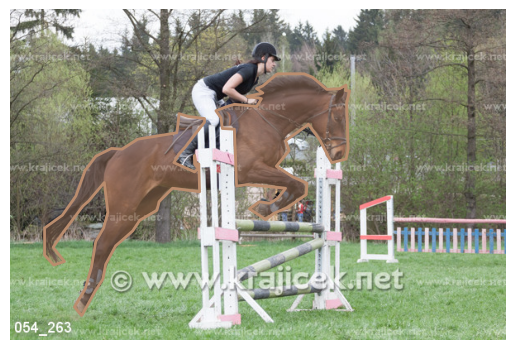

In [116]:
img = val_coco.loadImgs(val_image_ids[np.random.randint(0,len(val_image_ids))])[0]
display_bounded_image(val_coco, img, val_category_ids)

This section focuses on the data preprocessing:

Includes Normalization of pixel values

Standardization of picture size

scaling of bounding box dimensions based on picture standardization

MODEL 1 Custom Preprocessing and training/test/val

MODEL 2 Custom Preprocessing and training/test/val

Graphical displays and performance investigation